In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
import datetime
import mpu

## Funções Auxiliares

In [4]:
def normalized_cross_correlation(x, y):
    mx = np.mean(x)
    my = np.mean(y)
    dv = math.sqrt(np.var(x) * np.var(y))
    
    corr = 0

    if dv != 0:
        for xx,yy in zip(x,y):
            corr = corr + (((xx - mx) * (yy - my)) / dv)
    
    return corr/len(x)

In [5]:
def daily_normalized_correlation(df1, df2):
    corr = 0

    ind  = pd.DataFrame({"dayofyear": df1.index.dayofyear, "year": df1.index.year})

    for index, row in ind.iterrows():
        #print("Day:", row["dayofyear"], ", Year:", row["year"])
        station_a = df1[(df1.index.dayofyear == row["dayofyear"]) & (df1.index.year == row["year"])].irradiance.tolist()
        station_b = df2[(df2.index.dayofyear == row["dayofyear"]) & (df2.index.year == row["year"])].irradiance.tolist()
        v = np.var(station_a)
        corr = corr + normalized_cross_correlation(station_a, station_b)
    result = corr / len(ind)

    print("Normalized Correlation:", result)
    return result

In [6]:
def daily_weighted_correlation(df1, df2):
    corr = 0
    var = 0
    
    ind  = pd.DataFrame({"dayofyear": df1.index.dayofyear, "year": df1.index.year})

    for index, row in ind.iterrows():
        #print("Day:", row["dayofyear"], ", Year:", row["year"])
        station_a = df1[(df1.index.dayofyear == row["dayofyear"]) & (df1.index.year == row["year"])].irradiance.tolist()
        station_b = df2[(df2.index.dayofyear == row["dayofyear"]) & (df2.index.year == row["year"])].irradiance.tolist()
        v = np.var(station_a)
        #corr = corr + (np.correlate(station_a, station_b)[0] * v)
        corr = corr + (normalized_cross_correlation(station_a, station_b)* v)
        var = var + v
    result = corr / var   

    print("Weighted Correlation:", result)
    return result

In [7]:
def normalize(x, a, b):
    norm_x = []
    minx = min(x)
    maxx = max(x)
    for xx in x:
        res = ((b - a) * ((xx - minx) / (maxx - minx))) + a
        norm_x.append(res)
    
    return norm_x

In [8]:
def pearson_correlation_coef(x1, x2, nlags):

    lags = np.arange(0,nlags)
    pearson = []
    std = np.std(x1) * np.std(x2)

    for lag in lags:
        cv = np.cov(x1[lag:], x2[0:(len(x2)-lag)])
        pearson.append(cv[0,1] / std)

    return pearson

In [9]:
def cross_correlation_df(x1, x2, nlags):
    pearson = []
    lags = np.arange(0,nlags+1)

    for lag in lags:        
        pearson.append(x1.corr(x2.shift(lag)))
                       
    return pearson

In [10]:
def xcorr(x, y, maxlags=10):
    Nx = len(x)
    if Nx != len(y):
        raise ValueError('x and y must be equal length')

    c = np.correlate(x, y, mode=2)

    if maxlags is None:
        maxlags = Nx - 1

    if maxlags >= Nx or maxlags < 1:
        raise ValueError('maxlags must be None or strictly positive < %d' % Nx)

    c = c[Nx - 1 - maxlags:Nx + maxlags]

    return c

In [11]:
def normalize_array(x):
    xmax, xmin = x.max(), x.min()
    norm_x = (x - xmin)/(xmax - xmin)
    return norm_x

## Leitura de Dados

In [6]:
df = pd.read_pickle("df_oahu.pkl")
df_ssa_clean = pd.read_pickle("df_ssa_clean.pkl")
df_ssa_residual = pd.read_pickle("df_ssa_residual.pkl")

In [7]:
df.drop(columns=['AP_1', 'AP_7'], inplace=True)
df_ssa_clean.drop(columns=['AP_1', 'AP_7'], inplace=True)
df_ssa_residual.drop(columns=['AP_1', 'AP_7'], inplace=True)

In [8]:
# Get data form the interval of interest
interval = ((df.index >= '2010-06') & (df.index < '2011-06'))
df = df.loc[interval]
df_ssa_clean = df_ssa_clean.loc[interval]
df_ssa_residual = df_ssa_residual.loc[interval]

In [15]:
#lat = [21.31236,21.31303,21.31357,21.31183,21.31042,21.31268,21.31451,21.31533,21.30812,21.31276,21.30983,21.31141,21.31478,21.31179,21.31418,21.31034]
#lon = [-158.08463,-158.08505,-158.08424,-158.08554,-158.0853,-158.08688,-158.08534,-158.087,-158.07935,-158.08389,-158.08249,-158.07947,-158.07785,-158.08678,-158.08685,-158.08675]
lat = [21.31236,21.31303,21.31357,21.31183,21.31042,21.31268,21.31451,21.31533,21.30812,21.30983,21.31141,21.31179,21.31418,21.31034]
lon = [-158.08463,-158.08505,-158.08424,-158.08554,-158.0853,-158.08688,-158.08534,-158.087,-158.07935,-158.08249,-158.07947,-158.08678,-158.08685,-158.08675]
additional_info = pd.DataFrame({'station': df.columns, 'latitude': lat, 'longitude': lon })

In [16]:
resumo_df = df.groupby(by=df.index.date).sum()

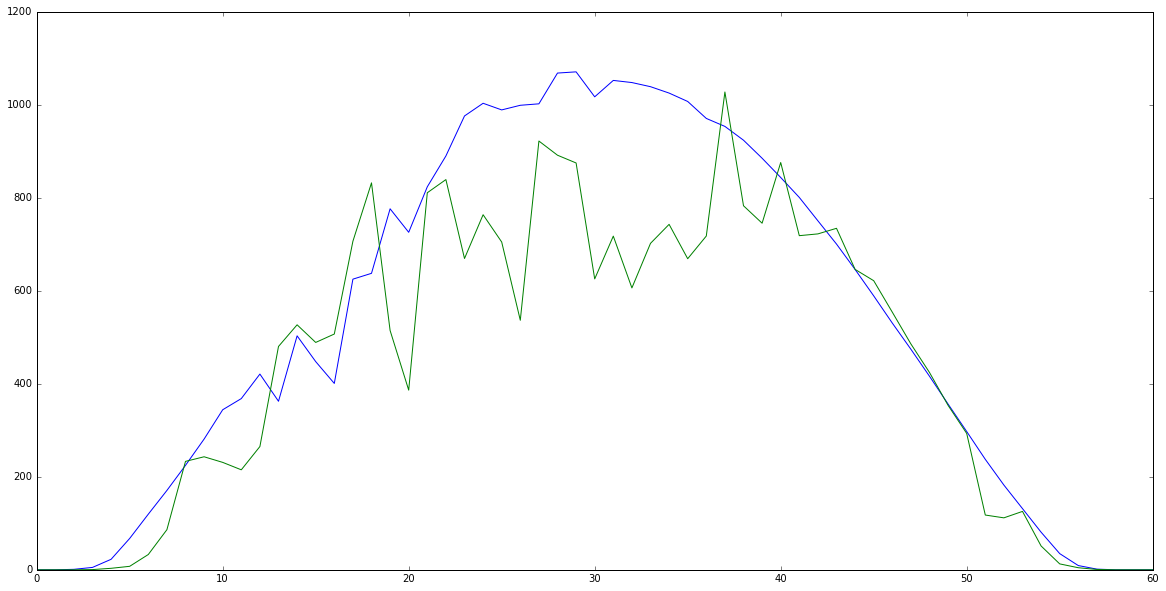

In [17]:
y_obs_clear = df[df.index.date == datetime.date(2010, 6, 11)].DHHL_3
#y_obs_min = df[df.index.date == datetime.date(2010, 12, 19)].DHHL_3
y_obs_cloud = df[df.index.date == datetime.date(2010, 8, 5)].DHHL_3

plt.figure(figsize=(20,10))
plt.plot( y_obs_clear.values)
plt.plot( y_obs_cloud.values)

In [18]:
x_date = pd.date_range("5:00", "20:00", freq="15min").strftime('%H:%M')

In [48]:
x_date

array(['05:00', '05:15', '05:30', '05:45', '06:00', '06:15', '06:30',
       '06:45', '07:00', '07:15', '07:30', '07:45', '08:00', '08:15',
       '08:30', '08:45', '09:00', '09:15', '09:30', '09:45', '10:00',
       '10:15', '10:30', '10:45', '11:00', '11:15', '11:30', '11:45',
       '12:00', '12:15', '12:30', '12:45', '13:00', '13:15', '13:30',
       '13:45', '14:00', '14:15', '14:30', '14:45', '15:00', '15:15',
       '15:30', '15:45', '16:00', '16:15', '16:30', '16:45', '17:00',
       '17:15', '17:30', '17:45', '18:00', '18:15', '18:30', '18:45',
       '19:00', '19:15', '19:30', '19:45', '20:00'],
      dtype='<U5')

In [19]:
xn = range(len(x_date))

In [50]:
np.arange(len(x_date))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

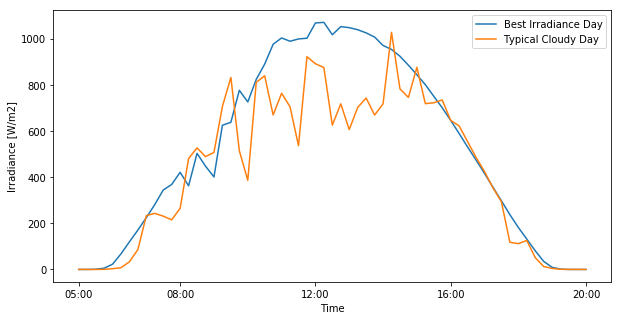

In [51]:
x_date = pd.date_range("5:00", "20:00", freq="15min").strftime('%H:%M')

xn = np.arange(len(x_date))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(xn, y_obs_clear.values, label='Best Irradiance Day')
plt.plot(xn, y_obs_cloud.values, label='Typical Cloudy Day')
ax.set_xlabel('Time')
ax.set_ylabel('Irradiance [W/m2]')
ax.legend(loc='best')
ticks = [0,12,28,44,60]
ax.set_xticks(ticks)
ax.set_xticklabels(x_date[ticks])
plt.show()

## Comparativo de decomposição SSA

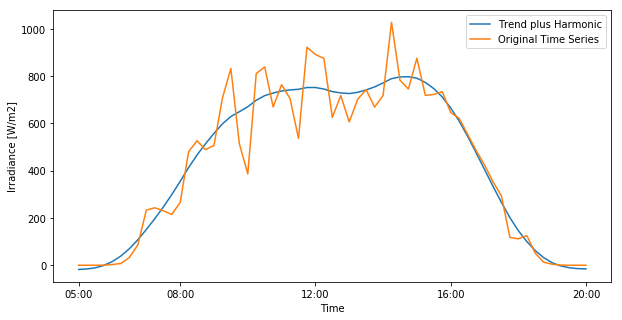

In [52]:
y_clean_cloud = df_ssa_clean[df_ssa_clean.index.date == datetime.date(2010, 8, 5)].DHHL_3
y_residual_cloud = df_ssa_residual[df_ssa_residual.index.date == datetime.date(2010, 8, 5)].DHHL_3

x_date = pd.date_range("5:00", "20:00", freq="15min").strftime('%H:%M')

xn = np.arange(len(x_date))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(xn, y_clean_cloud.values, label='Trend plus Harmonic')
plt.plot(xn, y_obs_cloud.values, label='Original Time Series')
ax.set_xlabel('Time')
ax.set_ylabel('Irradiance [W/m2]')
ax.legend(loc='best')
ticks = [0,12,28,44,60]
ax.set_xticks(ticks)
ax.set_xticklabels(x_date[ticks])
plt.show()

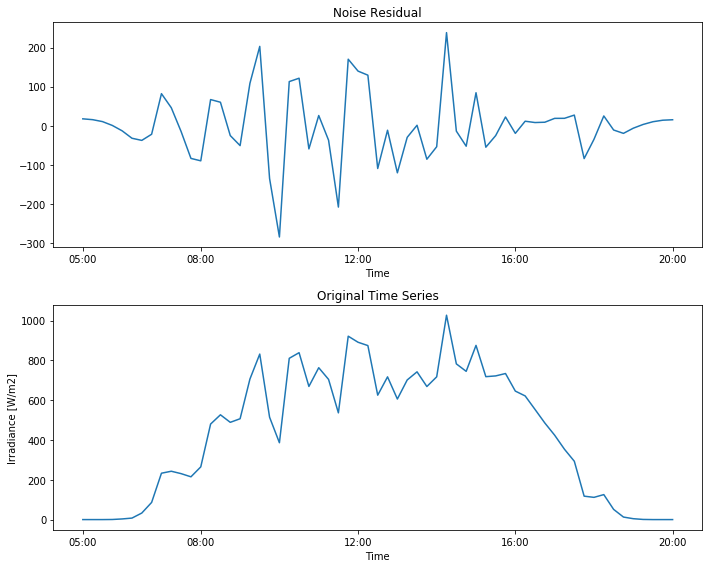

In [53]:
y_residual_cloud = df_ssa_residual[df_ssa_residual.index.date == datetime.date(2010, 8, 5)].DHHL_3
x_date = pd.date_range("5:00", "20:00", freq="15min").strftime('%H:%M')

xn = np.arange(len(x_date))

fig = plt.figure(figsize=(10,8))

# Serie Residuo
ax = fig.add_subplot(211)
plt.plot(xn, y_residual_cloud.values)
ax.set_xlabel('Time')
ax.set_title('Noise Residual')
#ax.legend(loc='best')
ticks = [0,12,28,44,60]
ax.set_xticks(ticks)
ax.set_xticklabels(x_date[ticks])

# Serie Original
ax2 = fig.add_subplot(212)
plt.plot(xn, y_obs_cloud.values)
ax2.set_xlabel('Time')
ax2.set_ylabel('Irradiance [W/m2]')
ax2.set_title('Original Time Series')
#ax2.legend(loc='best')
ticks = [0,12,28,44,60]
ax2.set_xticks(ticks)
ax2.set_xticklabels(x_date[ticks])

fig.tight_layout() 
plt.show()

## 4 Dias de observações

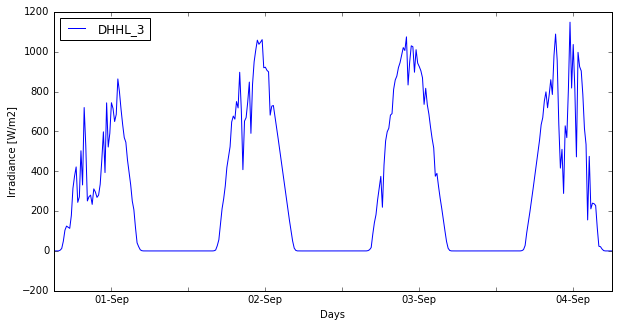

In [22]:
y_obs_4 = df[(df.index >= '2011-09-01') & (df.index <= '2011-09-05')].DHHL_3
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(y_obs_4)
ax.set_xlabel('Days')
ax.set_ylabel('Irradiance [W/m2]')
ax.legend(loc='best')
#ax.set_xticks(['08:00','12:00','16:00','20:00'])
ax.set_xticklabels(['01-Sep','','02-Sep','','03-Sep','','04-Sep'])
plt.show()

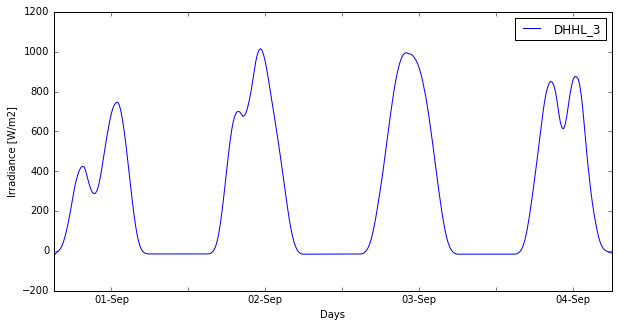

In [23]:
y_obs_4 = df_ssa_clean[(df_ssa_clean.index >= '2011-09-01') & (df_ssa_clean.index <= '2011-09-05')].DHHL_3
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(y_obs_4)
ax.set_xlabel('Days')
ax.set_ylabel('Irradiance [W/m2]')
ax.legend(loc='best')
#ax.set_xticks(['08:00','12:00','16:00','20:00'])
ax.set_xticklabels(['01-Sep','','02-Sep','','03-Sep','','04-Sep'])
plt.show()

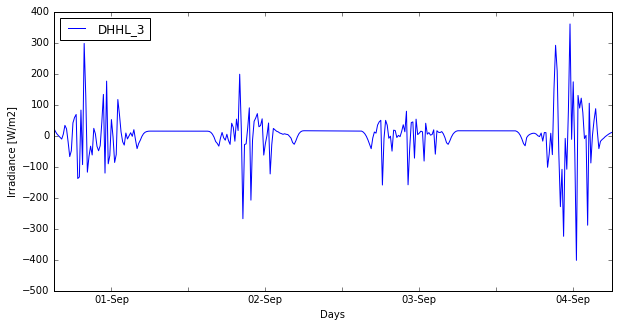

In [24]:
y_obs_4 = df_ssa_residual[(df_ssa_residual.index >= '2011-09-01') & (df_ssa_residual.index <= '2011-09-05')].DHHL_3
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(y_obs_4)
ax.set_xlabel('Days')
ax.set_ylabel('Irradiance [W/m2]')
ax.legend(loc='best')
#ax.set_xticks(['08:00','12:00','16:00','20:00'])
ax.set_xticklabels(['01-Sep','','02-Sep','','03-Sep','','04-Sep'])
plt.show()

## 1 dia de "Forecasting"

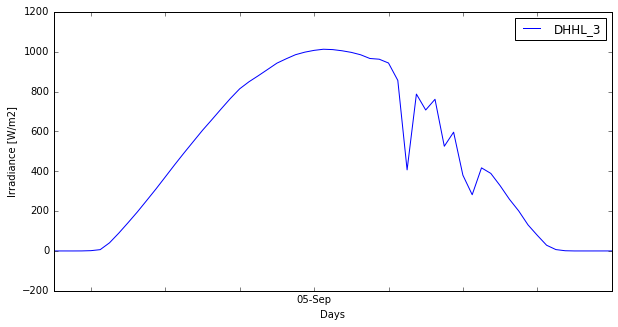

In [30]:
y_obs = df[(df.index >= '2011-09-08') & (df.index <= '2011-09-09')].DHHL_3
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(y_obs)
ax.set_xlabel('Days')
ax.set_ylabel('Irradiance [W/m2]')
ax.legend(loc='best')
#ax.set_xticks(['08:00','12:00','16:00','20:00'])
ax.set_xticklabels(['','','','05-Sep','','',''])
plt.show()

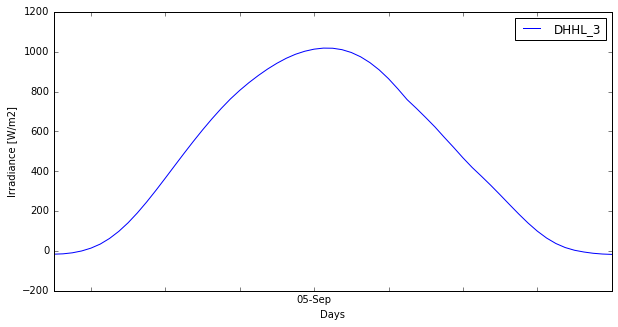

In [31]:
y_obs = df_ssa_clean[(df_ssa_clean.index >= '2011-09-08') & (df_ssa_clean.index <= '2011-09-09')].DHHL_3
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(y_obs)
ax.set_xlabel('Days')
ax.set_ylabel('Irradiance [W/m2]')
ax.legend(loc='best')
#ax.set_xticks(['08:00','12:00','16:00','20:00'])
ax.set_xticklabels(['','','','05-Sep','','',''])
plt.show()

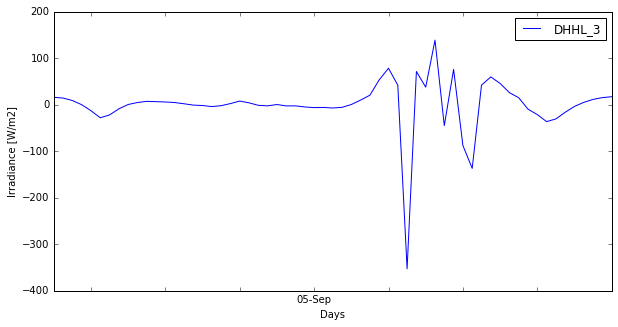

In [32]:
y_obs = df_ssa_residual[(df_ssa_residual.index >= '2011-09-08') & (df_ssa_residual.index <= '2011-09-09')].DHHL_3
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(y_obs)
ax.set_xlabel('Days')
ax.set_ylabel('Irradiance [W/m2]')
ax.legend(loc='best')
#ax.set_xticks(['08:00','12:00','16:00','20:00'])
ax.set_xticklabels(['','','','05-Sep','','',''])
plt.show()

1 dia de medição entre duas estações vizinhas

In [56]:
y_obs_1 = df[df.index.date == datetime.date(2010, 8, 5)].DHHL_3
y_obs_2 = df[df.index.date == datetime.date(2010, 8, 5)].AP_6


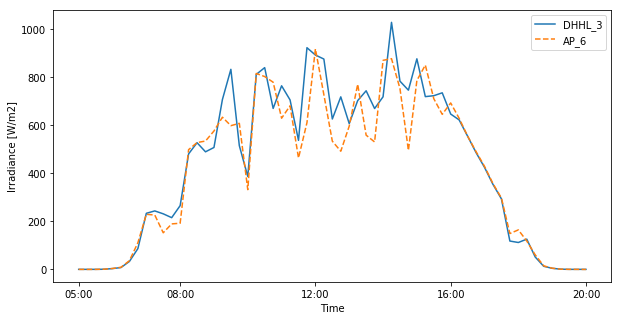

In [57]:
x_date = pd.date_range("5:00", "20:00", freq="15min").strftime('%H:%M')

xn = np.arange(len(x_date))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(xn, y_obs_1.values, label='DHHL_3')
plt.plot(xn, y_obs_2.values, ls="--", label='AP_6')

#rolmean = y_obs_1.rolling(window=3).mean()
#plt.plot(xn, rolmean, c="r", label='Rolling Mean')

ax.set_xlabel('Time')
ax.set_ylabel('Irradiance [W/m2]')
ax.legend(loc='best')
ticks = [0,12,28,44,60]
ax.set_xticks(ticks)
ax.set_xticklabels(x_date[ticks])
plt.show()

## Residual comparison

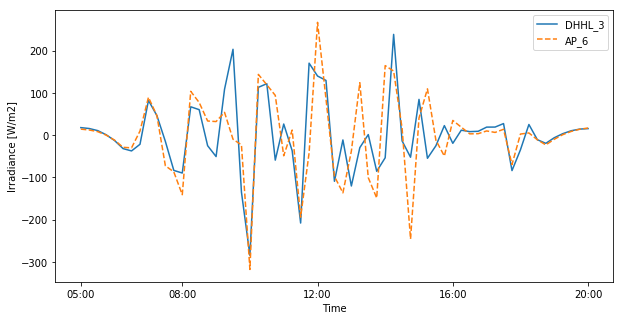

In [58]:
y_obs_1 = df_ssa_residual[df_ssa_residual.index.date == datetime.date(2010, 8, 5)].DHHL_3
y_obs_2 = df_ssa_residual[df_ssa_residual.index.date == datetime.date(2010, 8, 5)].AP_6

x_date = pd.date_range("5:00", "20:00", freq="15min").strftime('%H:%M')

xn = np.arange(len(x_date))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(xn, y_obs_1.values, label='DHHL_3')
plt.plot(xn, y_obs_2.values, ls="--", label='AP_6')

#rolmean = y_obs_1.rolling(window=3).mean()
#plt.plot(xn, rolmean, c="r", label='Rolling Mean')

ax.set_xlabel('Time')
ax.set_ylabel('Irradiance [W/m2]')
ax.legend(loc='best')
ticks = [0,12,28,44,60]
ax.set_xticks(ticks)
ax.set_xticklabels(x_date[ticks])
plt.show()

## Correlation Between Stations

Raw data

Definir um range fixo da paleta de cores!!

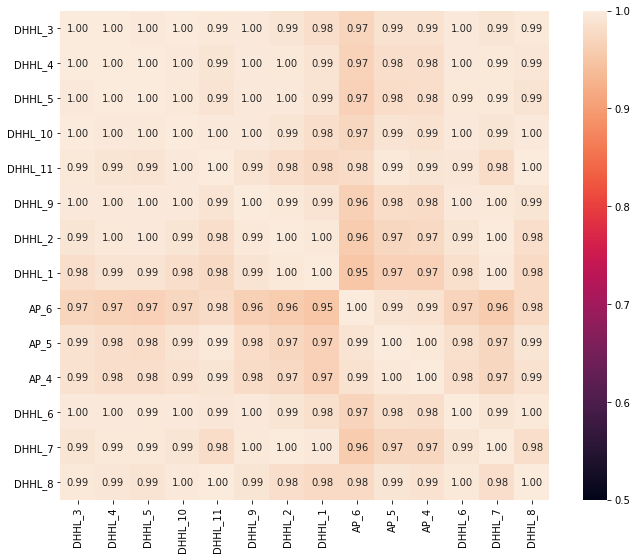

In [109]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True);
sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', vmin=.5)

Residual Data

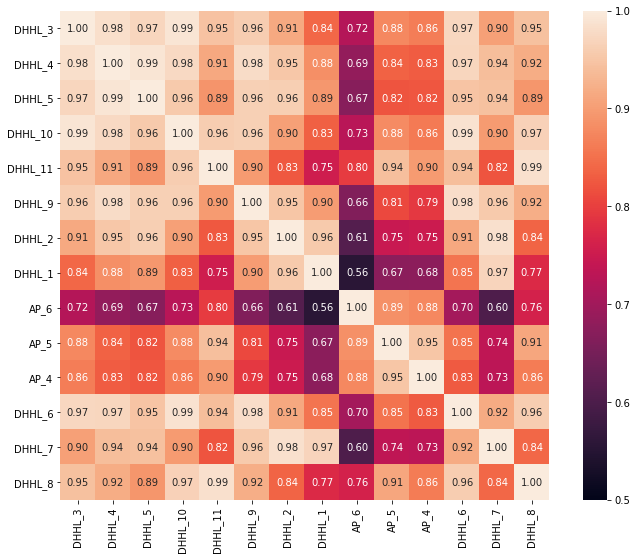

In [111]:
#correlation matrix
corrmat = df_ssa_residual.corr()
f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True);
sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', vmin=.5)

## Time-lagged correlation

In [ ]:
y_obs_1 = df_ssa_residual[df_ssa_residual.index.date == datetime.date(2010, 8, 5)].DHHL_3
y_obs_2 = df_ssa_residual[df_ssa_residual.index.date == datetime.date(2010, 8, 5)].AP_7

fig = plt.figure()
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax1.xcorr(y_obs_1, y_obs_2, usevlines=True, maxlags=50, normed=True, lw=2)
ax1.grid(True)
ax1.axhline(0, color='black', lw=2)

In [ ]:
fig = plt.figure()
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax1.acorr(y_obs_1, usevlines=True, maxlags=50, normed=True, lw=2)
ax1.grid(True)
ax1.axhline(0, color='black', lw=2)

## Diagrama de Hovmoller

In [124]:
def hovmoller_diagram(nlags, nlevels, df_hov_sample, additional_info, minutes_step = 15):
    nstations = len(df_hov_sample.columns)
    dists = []
    corrs = []
    for i in range(nstations):
        for j in range(i+1,nstations):

            col1 = df_hov_sample.columns[i] 
            col2 = df_hov_sample.columns[j]

            lat1 = additional_info[(additional_info.station == col1)].latitude.values[0]
            lon1 = additional_info[(additional_info.station == col1)].longitude.values[0]

            lat2 = additional_info[(additional_info.station == col2)].latitude.values[0]
            lon2 = additional_info[(additional_info.station == col2)].longitude.values[0]

            dist = mpu.haversine_distance((lat1, lon1), (lat2, lon2))
            #print("Dist from",col1,"-",col2,": ",dist)
            dists.append(dist)
#            corrs.append(xcorr(df_hov_sample[col1], df_hov_sample[col2], maxlags=nlags))
            pcorrs = cross_correlation_df(df_hov_sample[col1], df_hov_sample[col2], nlags)
            revpcorrs = cross_correlation_df(df_hov_sample[col2], df_hov_sample[col1], nlags)
            
            timelaggedcorrs = []
            timelaggedcorrs.extend(revpcorrs[::-1])
            timelaggedcorrs.extend(pcorrs[1:])
            corrs.append(timelaggedcorrs)

    dists = numpy.array(dists)
    corrs =  np.array(corrs)
    sort_dist_inds = dists.argsort()
    sorted_dists = dists[sort_dist_inds]
    sorted_corrs = corrs[sort_dist_inds]
    
    x = sorted_dists
    y = np.arange(-nlags, nlags+1, 1)
    X, Y = np.meshgrid(x,y)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    Z = normalize_array(sorted_corrs)
    plt.contourf(X.transpose(), Y.transpose(), Z, nlevels, norm=colors.PowerNorm(gamma=1. / 2.))
    plt.title('Cross-Correlation Diagram')
    plt.xlabel('Distance Between Stations [Km]')
    plt.ylabel('Time lag [min]')
    tick_labels = np.arange(-minutes_step*nlags,minutes_step*(nlags+1), minutes_step)
    ax.set_yticks(y)
    ax.set_yticklabels(tick_labels)

    cb = plt.colorbar()
    cb.set_label('Normalized Correlation')

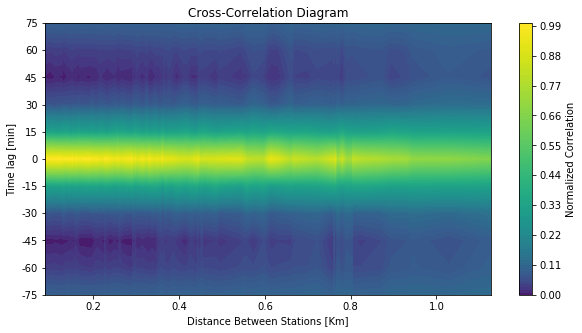

In [128]:
nlags = 5
nlevels = 100
#df_hov_sample = df_ssa_residual[(df_ssa_residual.index >= '2011-03-01') & (df_ssa_residual.index <= '2011-04-01')]
df_hov_sample = df_ssa_residual

hovmoller_diagram(nlags, nlevels, df_hov_sample, additional_info)

## ACF and PACF Plots

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

C:\Users\cseve\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
pivot = df.index[0]
start = pivot.strftime('%Y-%m-%d')
pivot = pivot + datetime.timedelta(days=34)
end = pivot.strftime('%Y-%m-%d')

In [11]:
#Set target and input variables 
target_station = 'DHHL_3'

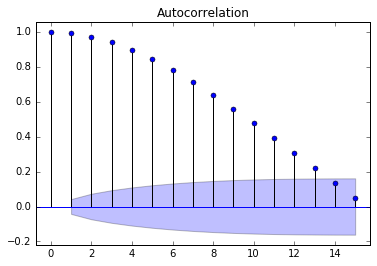

In [22]:
fig = plot_acf(df_ssa_clean[start:end][target_station].values, lags=15)

In [24]:
fig.savefig("acf_oahu_clean.png")

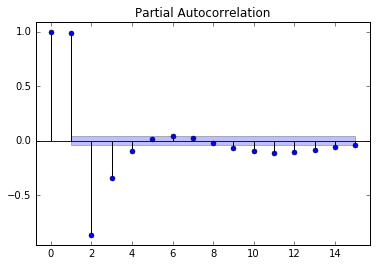

In [25]:
fig = plot_pacf(df_ssa_clean[start:end][target_station].values, lags=15)
fig.savefig("pacf_oahu_clean.png")

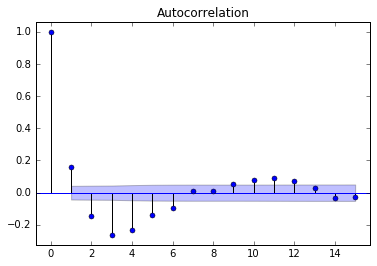

In [26]:
fig = plot_acf(df_ssa_residual[start:end][target_station].values, lags=15)
fig.savefig("acf_oahu_residual.png")

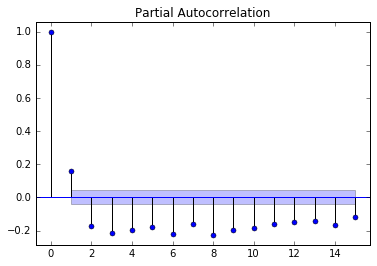

In [28]:
fig = plot_pacf(df_ssa_residual[start:end][target_station].values, lags=15)
fig.savefig("pacf_oahu_residual.png")

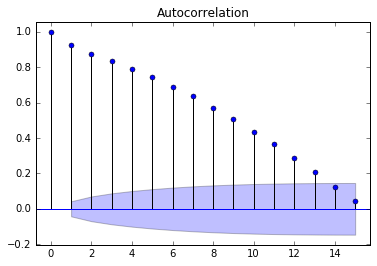

In [29]:
fig = plot_acf(df[start:end][target_station].values, lags=15)
fig.savefig("acf_oahu_raw.png")

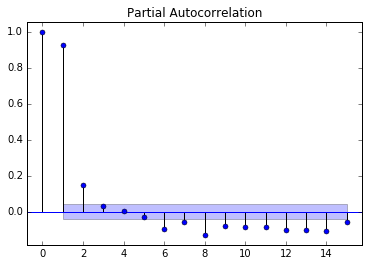

In [30]:
fig = plot_pacf(df[start:end][target_station].values, lags=15)
fig.savefig("pacf_oahu_raw.png")